# Data Analysis: Education, Literacy, and UN Speech Patterns in Africa

## Research Questions

### 1- Exploratory Research Question:
Is there a correlation between the frequency of education-related words in African country speeches and literacy rates?

### 2- Predictive Research Question:
Can we predict literacy rates using education expenditure and the frequency of education-related words in a multi-regression model?


## Methodology Overview

1. Data Integration: Combine UN speech data, literacy rates, and education expenditure data for African countries
2. Text Processing: Extract and count education-related terms from UN speeches
3. Exploratory Analysis: Examine relationships between variables
4. Statistical Analysis: Investigate correlations and regression modeling


## 1. Data Loading and Initial Setup


In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import scipy.stats as stats
import unicodedata
import re
from collections import Counter
import pandas as pd



### 1.1 Load UN Speeches Data


In [2]:
# Load UN Speeches from text files
sessions = np.arange(1, 80) # include all sessions
data = []

for session in sessions:
    directory = "./Data/TXT/Session "+str(str(session).zfill(2))+" - "+str(1945+session)
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename)) as f:
            if filename[0]==".": #ignore hidden files
                continue
            splt = filename.split("_")
            data.append([session, 1945+session, splt[0], f.read()])

# Create DataFrame and extract fundamental information about the data
df_speech = pd.DataFrame(data, columns=['Session', 'Year', 'ISO-alpha3 Code', 'Speech'])
print(f"Loaded {len(df_speech)} speeches from {df_speech['Year'].nunique()} years")
print(f"Year range: {df_speech['Year'].min()}-{df_speech['Year'].max()}")
print(f"Number of unique countries: {df_speech['ISO-alpha3 Code'].nunique()}")

# Check the dataframe
df_speech.tail(20)
#df_speech.head(20)


Loaded 10952 speeches from 79 years
Year range: 1946-2024
Number of unique countries: 200


,Session,Year,ISO-alpha3 Code,Speech
10932,79,2024,DEU,"Excellencies, Ladies and Gentlemen, \n \nwe li..."
10933,79,2024,PSE,"Mr. Philemon Yang, President of the United Nat..."
10934,79,2024,PER,Mr President of the United Nations General Ass...
10935,79,2024,LTU,"Dear President of the General Assembly, \nExce..."
10936,79,2024,SVN,"Mr President, \n \nMr Secretary-General, \n ..."
10937,79,2024,SYC,"Mr President, \nMr Secretary-General (if in t..."
10938,79,2024,KEN,President of the 79th Session of the UN Genera...
10939,79,2024,KHM,"Excellency Philémon Yang, President of the Gen..."
10940,79,2024,MDV,"Mr President, \n \nMr Secretary General, \n \n..."
10941,79,2024,ISR,"Mr. President, Ladies and gentlemen, I didn’t ..."


### 1.2 Load Country Codes and Regional Information


In [3]:
# Load country codes and regional information
codes_path = "./Data/UNSD_Methodology.csv"
df_codes = pd.read_csv(codes_path, sep=";")

# Extract fundamental information about the data
print(f"Country codes dataset shape: {df_codes.shape}")
print(f"Regions available: {df_codes['Region Name'].unique()}")

# Check the dataframe
df_codes.head(20)
#df_codes.tail(20)

Country codes dataset shape: (248, 15)
Regions available: ['Africa' 'Americas' nan 'Asia' 'Europe' 'Oceania']


,Global Code,Global Name,Region Code,Region Name,Sub-region Code,Sub-region Name,Intermediate Region Code,Intermediate Region Name,Country or Area,M49 Code,ISO-alpha2 Code,ISO-alpha3 Code,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS)
0,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Algeria,12,DZ,DZA,NaN,NaN,NaN
1,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Egypt,818,EG,EGY,NaN,NaN,NaN
2,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Libya,434,LY,LBY,NaN,NaN,NaN
3,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Morocco,504,MA,MAR,NaN,NaN,NaN
4,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Sudan,729,SD,SDN,x,NaN,NaN
5,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Tunisia,788,TN,TUN,NaN,NaN,NaN
6,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Western Sahara,732,EH,ESH,NaN,NaN,NaN
7,1,World,2.0,Africa,202.0,Sub-Saharan Africa,14.0,Eastern Africa,British Indian Ocean Territory,86,IO,IOT,NaN,NaN,NaN
8,1,World,2.0,Africa,202.0,Sub-Saharan Africa,14.0,Eastern Africa,Burundi,108,BI,BDI,x,x,NaN
9,1,World,2.0,Africa,202.0,Sub-Saharan Africa,14.0,Eastern Africa,Comoros,174,KM,COM,x,NaN,x


### 1.2.1 Merging the UN Speeches with Region-Country Information

In [4]:
# Merge speeches with country information
df_un_merged = pd.merge(
    df_speech[["ISO-alpha3 Code", "Session", "Year", "Speech"]],
    df_codes[["Country or Area", "Region Name", "ISO-alpha3 Code"]],
    on="ISO-alpha3 Code",
    how="left"
)

# Print fundamental information about the merged dataframe
print(f"Merged dataset shape: {df_un_merged.shape}")

# Print the unique countries without the region name
print("All rows with missing Region Name:")
print(df_un_merged[df_un_merged["Region Name"].isna()])

print("Unique countries/entities with missing Region Name:")
print(df_un_merged[df_un_merged["Region Name"].isna()][["ISO-alpha3 Code", "Country or Area"]].drop_duplicates()) # None of them in Africa, so skip.

# Check the dataframe
df_un_merged.head(20) # or df_un_merged.tail(20)

Merged dataset shape: (10952, 6)
All rows with missing Region Name:
      ISO-alpha3 Code  Session  Year  \
14                CSK        1  1946   
36                YUG        1  1946   
52                YUG        2  1947   
68                CSK        2  1947   
84                CSK        3  1948   
...               ...      ...   ...   
10008              EU       75  2020   
10306              EU       76  2021   
10491              EU       77  2022   
10619              EU       78  2023   
10838              EU       79  2024   

                                                  Speech Country or Area  \
14     I am a little more moved than usual as I rise ...             NaN   
36     In his report to the General Assembly, the Sec...             NaN   
52     The United Nations, and particularly those amo...             NaN   
68     May I congratulate my distinguished Mead and c...             NaN   
84     Mr. CLEMENTIS stated that, in connexion with t...             Na

,ISO-alpha3 Code,Session,Year,Speech,Country or Area,Region Name
0,LBR,1,1946,I give you the greetings of the Government and...,Liberia,Africa
1,UKR,1,1946,The day before yesterday the head of the deleg...,Ukraine,Europe
2,IRN,1,1946,During the first part of the first session of ...,Iran (Islamic Republic of),Asia
3,CAN,1,1946,"If were not anxious, like all my colleagues, ...",Canada,Americas
4,HTI,1,1946,A new world is being born from the fragments o...,Haiti,Americas
5,USA,1,1946,At the outset of what I have to say to the Gen...,United States of America,Americas
6,CUB,1,1946,The Cuban delegation earnestly hopes that the ...,Cuba,Americas
7,COL,1,1946,The Colombian delegation does not consider it ...,Colombia,Americas
8,CHL,1,1946,I shall occupy this rostrum for a few minutes ...,Chile,Americas
9,PER,1,1946,When I had the honour of addressing the Genera...,Peru,Americas


### 1.3 Extract Countries within the Africa Region


In [5]:
# Filter for African countries
df_africa = df_un_merged[df_un_merged["Region Name"] == "Africa"].copy()

# Print fundamental information about the dataframe
print(f"African countries dataset shape: {df_africa.shape}")
print(f"\nNumber of African countries: {df_africa['Country or Area'].nunique()}")
print(f"\nYear range for African speeches: {df_africa['Year'].min()}-{df_africa['Year'].max()}")
print(f"\nAfrican countries in dataset:\n{df_africa['Country or Area'].unique()}")
print(f"\nMissing values per column:\n{df_africa.isna().sum()}")

# Search for non-ASCII characters
for col in ["Speech"]:
    non_ascii_rows = []
    for idx, val in df_africa[col].astype(str).items():
        for ch in val:
            if not ch.isascii():
                non_ascii_rows.append(idx)
                break
    print(f"\nColumn: {col}")
    print(f"Rows with non-ASCII characters: {len(non_ascii_rows)}")
    if non_ascii_rows:
        print(df_africa.loc[non_ascii_rows, [col, "Year"]].head(10))

# Check the dataframe
df_africa.head(20)
df_africa.tail(20)

African countries dataset shape: (3001, 6)

Number of African countries: 54

Year range for African speeches: 1946-2024

African countries in dataset:
['Liberia' 'Egypt' 'South Africa' 'Ethiopia' 'Sudan' 'Morocco' 'Libya'
 'Tunisia' 'Ghana' 'Guinea' 'Cameroon' 'Mali' 'Congo' 'Niger'
 'Democratic Republic of the Congo' 'Central African Republic'
 'Madagascar' 'Togo' 'Sierra Leone' 'Gabon' 'Somalia' 'Nigeria' 'Senegal'
 'Burkina Faso' 'Algeria' 'Mauritania' 'Benin' 'Uganda' 'Chad'
 'United Republic of Tanzania' 'Burundi' 'Rwanda' 'Malawi' 'Kenya'
 'Zambia' 'Côte d’Ivoire' 'Lesotho' 'Gambia' 'Botswana' 'Mauritius'
 'Equatorial Guinea' 'Eswatini' 'Mozambique' 'Sao Tome and Principe'
 'Cabo Verde' 'Guinea-Bissau' 'Comoros' 'Seychelles' 'Angola' 'Djibouti'
 'Zimbabwe' 'Namibia' 'Eritrea' 'South Sudan']

Missing values per column:
ISO-alpha3 Code    0
Session            0
Year               0
Speech             0
Country or Area    0
Region Name        0
dtype: int64

Column: Speech
Rows with

,ISO-alpha3 Code,Session,Year,Speech,Country or Area,Region Name
10885,GAB,79,2024,"Mr President of the General Assembly, \nLadie...",Gabon,Africa
10886,MWI,79,2024,• Your Excellency Philémon Yang President of...,Malawi,Africa
10887,BEN,79,2024,"Mr President of the General Assembly, \nExcel...",Benin,Africa
10891,STP,79,2024,"Mr. Philemon Yang, President of the General As...",Sao Tome and Principe,Africa
10894,CMR,79,2024,"**MR PRESIDENT,** \n\nI am honoured to delive...",Cameroon,Africa
10895,LBR,79,2024,"\nH.E. Philemon Yangon, President of the 79th ...",Liberia,Africa
10898,UGA,79,2024,"The President of the General Assembly, \nExcel...",Uganda,Africa
10899,CPV,79,2024,"Excellencies Heads of State, Mr. President of ...",Cabo Verde,Africa
10901,EGY,79,2024,"\n**Mr. President,** \n**Ladies and Gentlemen...",Egypt,Africa
10902,SLE,79,2024,"MR. PRESIDENT, \n1.\tI congratulate Your Exce...",Sierra Leone,Africa


### 1.3.1 Clean & Preprocess the Africa Dataset

In [6]:
# Define a pre-process function to normalize all text to lowercase, whitespace between, no special characters etc.
def preprocess_text(s: str) -> str:
    if pd.isna(s):
        return s
    # normalize unicode accents → ascii
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("utf-8")

    # lowercase
    s = s.lower()

    # remove markdown bold/italics markers (i.e., ** and *)
    s = re.sub(r"\*+", "", s)

    # replace newlines/tabs with space
    s = re.sub(r"[\n\t\r]+", " ", s)

    # collapse multiple spaces into one
    s = re.sub(r"\s+", " ", s)

    # strip leading/trailing spaces
    return s.strip()

# Apply to Speech
df_africa["Speech"] = df_africa["Speech"].apply(preprocess_text)

# Check the dataframe
df_africa.head(20) # or df_africa.tail(20)


,ISO-alpha3 Code,Session,Year,Speech,Country or Area,Region Name
0,LBR,1,1946,i give you the greetings of the government and...,Liberia,Africa
15,EGY,1,1946,it is for me a great pleasure to bring you tod...,Egypt,Africa
59,ZAF,2,1947,"during the recent war, many of the nations rep...",South Africa,Africa
65,LBR,2,1947,the liberian delegation wishes to associate it...,Liberia,Africa
67,EGY,2,1947,"in the name of my delegation, permit me to ass...",Egypt,Africa
83,EGY,3,1948,khashaba pasha stated that on the occasion of ...,Egypt,Africa
91,LBR,3,1948,mr. cooper stated that all the nations of the ...,Liberia,Africa
92,ZAF,3,1948,mr. louw expressed his thanks to france on beh...,South Africa,Africa
118,ZAF,4,1949,mr. jooste stated that it was the wish of his ...,South Africa,Africa
122,LBR,4,1949,"mr. king, after congratulating the president u...",Liberia,Africa


### 1.4  Load Literacy Rates Data


In [7]:
# Load literacy rates dataset
df_literacy = pd.read_csv("Data/WB_GS_SE_ADT.csv")

# Print fundamental information about the data
print(f"Literacy dataset shape: {df_literacy.shape}")
print(f"Year range: {df_literacy['TIME_PERIOD'].min()}-{df_literacy['TIME_PERIOD'].max()}")
print(f"Missing values: {df_literacy['OBS_VALUE'].isna().mean()*100:.1f}%")
print(f"Number of countries/regions: {df_literacy['REF_AREA_LABEL'].nunique()}\n")
print(df_literacy.info())     # column names + types
print("\nCountries/Regions:", df_literacy["REF_AREA_LABEL"].nunique())
print(df_literacy["REF_AREA_LABEL"].unique()[:10])   # first 10 countries

print("\nSex categories:", df_literacy["SEX_LABEL"].unique())
print("\nAge groups:", df_literacy["AGE_LABEL"].unique())
print("\nUrbanisation categories:", df_literacy["URBANISATION_LABEL"].unique())
print("\nIndicators:", df_literacy["INDICATOR_LABEL"].unique())

# Check the dataframe
df_literacy.head(20)

Literacy dataset shape: (101760, 35)
Year range: 1960-2023
Missing values: 83.3%
Number of countries/regions: 265

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101760 entries, 0 to 101759
Data columns (total 35 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   STRUCTURE               101760 non-null  object 
 1   STRUCTURE_ID            101760 non-null  object 
 2   ACTION                  101760 non-null  object 
 3   FREQ                    101760 non-null  object 
 4   FREQ_LABEL              101760 non-null  object 
 5   REF_AREA                101760 non-null  object 
 6   REF_AREA_LABEL          101760 non-null  object 
 7   INDICATOR               101760 non-null  object 
 8   INDICATOR_LABEL         101760 non-null  object 
 9   SEX                     101760 non-null  object 
 10  SEX_LABEL               101760 non-null  object 
 11  AGE                     101760 non-null  object 
 12  AGE_LABEL    

,STRUCTURE,STRUCTURE_ID,ACTION,FREQ,FREQ_LABEL,REF_AREA,REF_AREA_LABEL,INDICATOR,INDICATOR_LABEL,SEX,...,DATABASE_ID,DATABASE_ID_LABEL,UNIT_MULT,UNIT_MULT_LABEL,UNIT_TYPE,UNIT_TYPE_LABEL,OBS_STATUS,OBS_STATUS_LABEL,OBS_CONF,OBS_CONF_LABEL
0,datastructure,WB.DATA360:DS_DATA360(1.1),I,A,Annual,ABW,Aruba,WB_GS_SE_ADT,Literacy rate (%),F,...,WB_GS,Gender Statistics,0,Units,RATIO,Ratio,O,Missing value,PU,Public
1,datastructure,WB.DATA360:DS_DATA360(1.1),I,A,Annual,AFE,Africa Eastern and Southern,WB_GS_SE_ADT,Literacy rate (%),F,...,WB_GS,Gender Statistics,0,Units,RATIO,Ratio,O,Missing value,PU,Public
2,datastructure,WB.DATA360:DS_DATA360(1.1),I,A,Annual,AFG,Afghanistan,WB_GS_SE_ADT,Literacy rate (%),F,...,WB_GS,Gender Statistics,0,Units,RATIO,Ratio,O,Missing value,PU,Public
3,datastructure,WB.DATA360:DS_DATA360(1.1),I,A,Annual,AFW,Africa Western and Central,WB_GS_SE_ADT,Literacy rate (%),F,...,WB_GS,Gender Statistics,0,Units,RATIO,Ratio,O,Missing value,PU,Public
4,datastructure,WB.DATA360:DS_DATA360(1.1),I,A,Annual,AGO,Angola,WB_GS_SE_ADT,Literacy rate (%),F,...,WB_GS,Gender Statistics,0,Units,RATIO,Ratio,O,Missing value,PU,Public
5,datastructure,WB.DATA360:DS_DATA360(1.1),I,A,Annual,ALB,Albania,WB_GS_SE_ADT,Literacy rate (%),F,...,WB_GS,Gender Statistics,0,Units,RATIO,Ratio,O,Missing value,PU,Public
6,datastructure,WB.DATA360:DS_DATA360(1.1),I,A,Annual,AND,Andorra,WB_GS_SE_ADT,Literacy rate (%),F,...,WB_GS,Gender Statistics,0,Units,RATIO,Ratio,O,Missing value,PU,Public
7,datastructure,WB.DATA360:DS_DATA360(1.1),I,A,Annual,ARB,Arab World,WB_GS_SE_ADT,Literacy rate (%),F,...,WB_GS,Gender Statistics,0,Units,RATIO,Ratio,O,Missing value,PU,Public
8,datastructure,WB.DATA360:DS_DATA360(1.1),I,A,Annual,ARE,United Arab Emirates,WB_GS_SE_ADT,Literacy rate (%),F,...,WB_GS,Gender Statistics,0,Units,RATIO,Ratio,O,Missing value,PU,Public
9,datastructure,WB.DATA360:DS_DATA360(1.1),I,A,Annual,ARG,Argentina,WB_GS_SE_ADT,Literacy rate (%),F,...,WB_GS,Gender Statistics,0,Units,RATIO,Ratio,O,Missing value,PU,Public


### 1.4.1 Merge Literacy Rates with Africa Dataset

In [8]:
# First, let's prepare the literacy data similar to what's done in cell 32
# Filter literacy data for Total population, 15+ age group, and non-null values
df_literacy_for_merge = df_literacy[
    (df_literacy['SEX_LABEL'] == 'Total') & 
    (df_literacy['AGE_LABEL'] == '15 years old and over') &
    (df_literacy['OBS_VALUE'].notna())
].copy()

# Rename columns for easier merging
df_literacy_for_merge = df_literacy_for_merge.rename(columns={
    'REF_AREA_LABEL': 'Country or Area',
    'TIME_PERIOD': 'Year', 
    'OBS_VALUE': 'Literacy_Rate'
})

# Check country name matching between datasets
africa_countries = set(df_africa['Country or Area'].unique())
literacy_countries = set(df_literacy_for_merge['Country or Area'].unique())

print("Countries in Africa dataset:", len(africa_countries))
print("Countries in literacy dataset:", len(literacy_countries))
print("Common countries:", len(africa_countries & literacy_countries))
print("\nCountries with literacy data available for Africa:")
print(sorted(africa_countries & literacy_countries))

# Merge literacy rates with Africa dataset
# Use left join to keep all Africa data, adding literacy rate where available
df_africa_with_literacy = pd.merge(
    df_africa,
    df_literacy_for_merge[['Country or Area', 'Year', 'Literacy_Rate']],
    on=['Country or Area', 'Year'],
    how='left'
)

# Print the resulting information
print(f"\nOriginal Africa dataset shape: {df_africa.shape}")
print(f"After adding literacy rates: {df_africa_with_literacy.shape}")
print(f"Rows with literacy data: {df_africa_with_literacy['Literacy_Rate'].notna().sum()}")
print(f"Coverage: {df_africa_with_literacy['Literacy_Rate'].notna().mean()*100:.1f}%")

# Update the main Africa dataframe
df_africa = df_africa_with_literacy

# Show sample of merged data
df_africa[df_africa['Literacy_Rate'].notna()]



Countries in Africa dataset: 54
Countries in literacy dataset: 209
Common countries: 47

Countries with literacy data available for Africa:
['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Sao Tome and Principe', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan', 'Sudan', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe']

Original Africa dataset shape: (3001, 6)
After adding literacy rates: (3001, 7)
Rows with literacy data: 244
Coverage: 8.1%


,ISO-alpha3 Code,Session,Year,Speech,Country or Area,Region Name,Literacy_Rate
426,SOM,27,1972,"mr. president, my foreign secretary had hoped ...",Somalia,Africa,5.404650
551,CAF,30,1975,"243. in the name of mr. jean-bedel bokassa, pr...",Central African Republic,Africa,18.236170
554,BFA,30,1975,once again i should like to reaffirm in a few ...,Burkina Faso,Africa,8.830230
575,CMR,31,1976,our session opened a few days ago under the pr...,Cameroon,Africa,41.216209
590,SWZ,31,1976,"mr. president, i wish to express my sincere co...",Eswatini,Africa,55.325039
...,...,...,...,...,...,...,...
2882,ZWE,77,2022,it is my singular honour to deliver this state...,Zimbabwe,Africa,89.849998
2885,BFA,77,2022,i would like to begin by expressing my warmest...,Burkina Faso,Africa,34.490002
2886,GNB,77,2022,i would like to warmly congratulate mr. csaba ...,Guinea-Bissau,Africa,53.900002
2892,MDG,77,2022,"at the outset, allow me to address mr. korosi,...",Madagascar,Africa,77.480003


### 1.5 Load Education Expenditure Data


In [9]:
# Load education expenditure dataset (Government expenditure on education as % of GDP)
df_edu_exp = pd.read_csv("Data/UIS_EDSTATS_XGDP_FSGOV.csv")

# Print fundamental information about the data
print(f"Education expenditure dataset shape: {df_edu_exp.shape}")
print(f"Year range: {df_edu_exp['TIME_PERIOD'].min()}-{df_edu_exp['TIME_PERIOD'].max()}")
print(f"Missing values: {df_edu_exp['OBS_VALUE'].isna().mean()*100:.1f}%")
print(f"Number of countries: {df_edu_exp['REF_AREA_LABEL'].nunique()}")
print(f"\nExpenditure statistics:")
print(df_edu_exp['OBS_VALUE'].describe())

# Check the dataframe
df_edu_exp.head()

Education expenditure dataset shape: (5334, 45)
Year range: 1970-2024
Missing values: 0.0%
Number of countries: 206

Expenditure statistics:
count    5334.000000
mean        4.352125
std         2.146107
min         0.000000
25%         3.047476
50%         4.192725
75%         5.376110
max        66.900307
Name: OBS_VALUE, dtype: float64


,STRUCTURE,STRUCTURE_ID,ACTION,FREQ,FREQ_LABEL,REF_AREA,REF_AREA_LABEL,INDICATOR,INDICATOR_LABEL,SEX,...,DATA_SOURCE_LABEL,UNIT_TYPE,UNIT_TYPE_LABEL,TIME_FORMAT,TIME_FORMAT_LABEL,COMMENT_OBS,OBS_STATUS,OBS_STATUS_LABEL,OBS_CONF,OBS_CONF_LABEL
0,datastructure,WB.DATA360:DS_DATA360(1.2),I,A,Annual,ABW,Aruba,UIS_EDSTATS_XGDP_FSGOV,Government expenditure on education as a perce...,_T,...,Education Statistics,RATIO,Ratio,602,CCYY,NaN,A,Normal value,PU,Public
1,datastructure,WB.DATA360:DS_DATA360(1.2),I,A,Annual,ABW,Aruba,UIS_EDSTATS_XGDP_FSGOV,Government expenditure on education as a perce...,_T,...,Education Statistics,RATIO,Ratio,602,CCYY,NaN,A,Normal value,PU,Public
2,datastructure,WB.DATA360:DS_DATA360(1.2),I,A,Annual,ABW,Aruba,UIS_EDSTATS_XGDP_FSGOV,Government expenditure on education as a perce...,_T,...,Education Statistics,RATIO,Ratio,602,CCYY,NaN,A,Normal value,PU,Public
3,datastructure,WB.DATA360:DS_DATA360(1.2),I,A,Annual,ABW,Aruba,UIS_EDSTATS_XGDP_FSGOV,Government expenditure on education as a perce...,_T,...,Education Statistics,RATIO,Ratio,602,CCYY,NaN,A,Normal value,PU,Public
4,datastructure,WB.DATA360:DS_DATA360(1.2),I,A,Annual,ABW,Aruba,UIS_EDSTATS_XGDP_FSGOV,Government expenditure on education as a perce...,_T,...,Education Statistics,RATIO,Ratio,602,CCYY,NaN,A,Normal value,PU,Public


### 1.5.1. Merge Education Expenditure Data with African Dataset

In [10]:
# Merge Education Expenditure Data with Africa Dataset

# Prepare education expenditure data
df_edu_exp_for_merge = df_edu_exp[df_edu_exp['OBS_VALUE'].notna()].copy()

# Rename columns for easier merging
df_edu_exp_for_merge = df_edu_exp_for_merge.rename(columns={
    'REF_AREA_LABEL': 'Country or Area',
    'TIME_PERIOD': 'Year',
    'OBS_VALUE': 'Education_Expenditure_GDP_Pct'
})

# Check which African countries have education expenditure data
african_countries_in_speeches = set(df_africa['Country or Area'].unique())
african_countries_in_expenditure = set(df_edu_exp_for_merge['Country or Area'].unique())

print("Countries in Africa speeches dataset:", len(african_countries_in_speeches))
print("Countries in expenditure dataset:", len(african_countries_in_expenditure))

# Find common countries
common_countries = african_countries_in_speeches & african_countries_in_expenditure
print(f"Common countries between Africa and expenditure datasets: {len(common_countries)}")
print("Common countries:", common_countries)

# Merge education expenditure with Africa dataset
# Use left join to keep all Africa data, adding expenditure where available
df_africa_with_expenditure = pd.merge(
    df_africa,
    df_edu_exp_for_merge[['Country or Area', 'Year', 'Education_Expenditure_GDP_Pct']],
    on=['Country or Area', 'Year'],
    how='left'
)

# Update the main Africa dataframe
df_africa = df_africa_with_expenditure

Countries in Africa speeches dataset: 54
Countries in expenditure dataset: 206
Common countries between Africa and expenditure datasets: 48
Common countries: {'Comoros', 'Sudan', 'South Africa', 'Algeria', 'Seychelles', 'Kenya', 'Eswatini', 'Botswana', 'Mauritius', 'Sao Tome and Principe', 'Zambia', 'Madagascar', 'Mali', 'Nigeria', 'Gabon', 'Tunisia', 'Malawi', 'Cameroon', 'South Sudan', 'Liberia', 'Burundi', 'Niger', 'Guinea-Bissau', 'Morocco', 'Lesotho', 'Mozambique', 'Namibia', 'Senegal', 'Burkina Faso', 'Djibouti', 'Angola', 'Eritrea', 'Mauritania', 'Cabo Verde', 'Zimbabwe', 'Togo', 'Ghana', 'Guinea', 'Libya', 'Benin', 'Sierra Leone', 'Uganda', 'Chad', 'Equatorial Guinea', 'Rwanda', 'Ethiopia', 'Central African Republic', 'Somalia'}


In [11]:
# Print the resulting information
print(f"\nOriginal Africa dataset shape: {df_africa.shape}")
print(f"After adding education expenditure: {df_africa_with_expenditure.shape}")
print(f"Rows with expenditure data: {df_africa_with_expenditure['Education_Expenditure_GDP_Pct'].notna().sum()}")
print(f"Expenditure coverage: {df_africa_with_expenditure['Education_Expenditure_GDP_Pct'].notna().mean()*100:.1f}%")



Original Africa dataset shape: (3001, 8)
After adding education expenditure: (3001, 8)
Rows with expenditure data: 1085
Expenditure coverage: 36.2%


In [12]:
print("\nEducation expenditure statistics for African countries:")
print(df_africa['Education_Expenditure_GDP_Pct'].describe())

# Show sample of merged data with expenditure
sample_with_expenditure = df_africa[df_africa['Education_Expenditure_GDP_Pct'].notna()].head(10)
print(f"\nSample of African countries with education expenditure data:")
print(sample_with_expenditure[['Country or Area', 'Year', 'Education_Expenditure_GDP_Pct', 'Literacy_Rate']].to_string())

# Show rows where both Literacy_Rate and Education_Expenditure_GDP_Pct are not NA
both_notna = df_africa[
    df_africa['Literacy_Rate'].notna() & df_africa['Education_Expenditure_GDP_Pct'].notna()
]
# Show the rows that have both Literacy Rate and Education Expenditure_GDP
print(f"\nRows where both Literacy Rate and Education Expenditure are available: {both_notna.shape[0]}")
both_notna[['Country or Area', 'Year', 'Literacy_Rate', 'Education_Expenditure_GDP_Pct']].head(10)

# print the year range of the data
print(f"\nYear range of the data: {both_notna['Year'].min()} to {both_notna['Year'].max()}")

# update the main africa dataframe
df_africa = both_notna.copy()



Education expenditure statistics for African countries:
count    1085.000000
mean        4.193607
std         2.454733
min         0.127174
25%         2.572222
50%         3.736495
75%         5.438300
max        44.333981
Name: Education_Expenditure_GDP_Pct, dtype: float64

Sample of African countries with education expenditure data:
    Country or Area  Year  Education_Expenditure_GDP_Pct  Literacy_Rate
370          Zambia  1970                        4.38781            NaN
380            Togo  1970                        1.49681            NaN
389        Cameroon  1971                        3.07987            NaN
395          Uganda  1971                        3.16105            NaN
399           Kenya  1971                        3.92982            NaN
408          Zambia  1971                        6.09535            NaN
410        Ethiopia  1971                        1.19767            NaN
412           Niger  1971                        1.05227            NaN
413       Mau

## 2. Education-Related Terms Extract

We extract education-related terms from the UNESCO thesaurus to identify relevant vocabulary in UN speeches.


In [13]:
# Load education-related terms from UNESCO thesaurus
with open("./Data/sh85040989.json", "r", encoding="utf-8") as f:
    education_glossary_data = json.load(f)

# Collect all the @value entries from the JSON, as education-related words are encoded within.
education_related_terms = []
for entry in education_glossary_data:
    for key, values in entry.items():
        if isinstance(values, list):
            for value in values:
                if isinstance(value, dict) and "@value" in value:
                    education_related_terms.append(value["@value"])

# Create DataFrame
df_education_terms = pd.DataFrame(education_related_terms, columns=["Education-related Key Word"])
print(f"Initial education terms extracted: {len(df_education_terms)}")
df_education_terms.head(20)


Initial education terms extracted: 942


,Education-related Key Word
0,Human resource development
1,Pictures in education
2,Pictures in education
3,150 $aEducation$xAustralian states$xFinance
4,Education--Australian states--Finance
5,Education--Australian states--Finance
6,Inclusive education
7,Inclusive education
8,150 $aEducation$xEconometric models
9,Education--Econometric models


### 2.1 Clean & Preprocess Education Terms Dataset

In [14]:
# Clean and preprocess education terms
df_education_terms_clean = df_education_terms.drop_duplicates()
print(f"After removing duplicates: {len(df_education_terms_clean)}")

# Remove entries that start with digits (library classification codes)
df_education_terms_clean = df_education_terms_clean[
    ~df_education_terms_clean["Education-related Key Word"].str[0].str.isdigit()
]
print(f"After removing entries starting with digits: {len(df_education_terms_clean)}")

# Replace double dashes with spaces
df_education_terms_clean["Education-related Key Word"] = df_education_terms_clean[
    "Education-related Key Word"].str.replace("--", " ")

# Normalize whitespaces and convert to lowercase
df_education_terms_clean["Education-related Key Word"] = df_education_terms_clean[
    "Education-related Key Word"].str.replace(r"\s+", " ", regex=True).str.strip().str.lower()

# Ensure ASCII-only characters
df_education_terms_clean["Education-related Key Word"] = df_education_terms_clean[
    "Education-related Key Word"].str.encode('ascii', 'ignore').str.decode('ascii')

print(f"Final cleaned education terms: {len(df_education_terms_clean)}")
print("\nSample cleaned terms:")
print(df_education_terms_clean.head(15))

#TODO: using the nltk library, check out the distribution of the education-related terms.


After removing duplicates: 516
After removing entries starting with digits: 387
Final cleaned education terms: 387

Sample cleaned terms:
                  Education-related Key Word
0                 human resource development
1                      pictures in education
4        education australian states finance
6                        inclusive education
9               education econometric models
12                 education reference books
14                           home and school
16                    compensatory education
18                   libraries and education
20                           youth education
22  education study and teaching (preschool)
25          education periodicals publishing
28                        education taxation
31   education us states aims and objectives
33                       technical education


## 3. Education-Related Word Frequency Calculation

Expected Output: A new column in `df_africa` containing education word frequencies for each speech, which will enable correlation analysis with literacy rates.


In [15]:
# Download required NLTK libraries
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bugrasipahioglu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bugrasipahioglu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/bugrasipahioglu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/bugrasipahioglu/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bugrasipahioglu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
# Count education-related words in all speeches (of African countries)
def count_education_mentions(text: str):
    if pd.isna(text) or text.strip() == "":
        return {"n_tokens": 0, "edu_single_count": 0, "edu_phrase_count": 0,
                "edu_total": 0, "edu_per": 0.0}
    
    # Use cleaned text directly, convert to lowercase for matching
    text_lower = text.lower()
    
    # Tokenize for counting total tokens
    toks = text_lower.split()
    n = len(toks)
    if n == 0:
        return {"n_tokens": 0, "edu_single_count": 0, "edu_phrase_count": 0,
                "edu_total": 0, "edu_per": 0.0}

    # Get education terms from cleaned dataset
    education_terms = df_education_terms_clean["Education-related Key Word"].tolist()
    
    # Separate single words and phrases
    single_words = [term for term in education_terms if len(term.split()) == 1]
    phrases = [term for term in education_terms if len(term.split()) > 1]
    
    # Count single-word matches
    c_tok = Counter(toks)
    single = sum(c_tok.get(w, 0) for w in single_words)
    
    # Count phrase matches
    phrase_count = 0
    for phrase in phrases:
        phrase_count += text_lower.count(phrase)
    
    total = single + phrase_count
    return {
        "n_tokens": n,
        "edu_single_count": single,
        "edu_phrase_count": phrase_count,
        "edu_total": total,
        "edu_per": total / n * 100.0
    }

# Extract the education-related words from the speeches
res = df_africa["Speech"].apply(count_education_mentions).apply(pd.Series)
cols = ["n_tokens","edu_single_count","edu_phrase_count","edu_total","edu_per"]
df_africa = df_africa.drop(columns=cols, errors="ignore").join(res)

# Look at rows where edu_phrase_count is non-zero
nonzero_phrase = df_africa[df_africa["edu_phrase_count"] > 0]
print(nonzero_phrase[["Country or Area", "n_tokens", "edu_single_count",
                      "edu_phrase_count", "edu_total", "edu_per"]].head())

     Country or Area  n_tokens  edu_single_count  edu_phrase_count  edu_total  \
2051    South Africa    1862.0               2.0               1.0        3.0   
2106         Burundi    1631.0               6.0               1.0        7.0   
2365        Botswana    1748.0               2.0               1.0        3.0   
2853          Angola    1231.0               2.0               1.0        3.0   
2892      Madagascar    2308.0              14.0               1.0       15.0   

       edu_per  
2051  0.161117  
2106  0.429185  
2365  0.171625  
2853  0.243704  
2892  0.649913  


## 4. Data Preparation and Integration

### 4.1 Filter rows that have expenditure & literacy rates


In [17]:
# Filter df_africa to only include rows where both Literacy_Rate and Education_Expenditure_GDP_Pct are not NA
df_africa = df_africa[df_africa["Literacy_Rate"].notna() & df_africa["Education_Expenditure_GDP_Pct"].notna()]
df_africa.head(10)

# number of countries that have both Literacy Rate and Education Expenditure_GDP
print(f"\nNumber of countries that have both Literacy Rate and Education Expenditure: {df_africa['Country or Area'].nunique()}")

# number of unique years in the data
print(f"\nNumber of unique years in the data: {df_africa['Year'].nunique()}")


Number of countries that have both Literacy Rate and Education Expenditure: 43

Number of unique years in the data: 36


## 5. Exploratory Data Analysis

### 5.1 Trends Over Time: Education-related terms frequency  & Literacy Rates


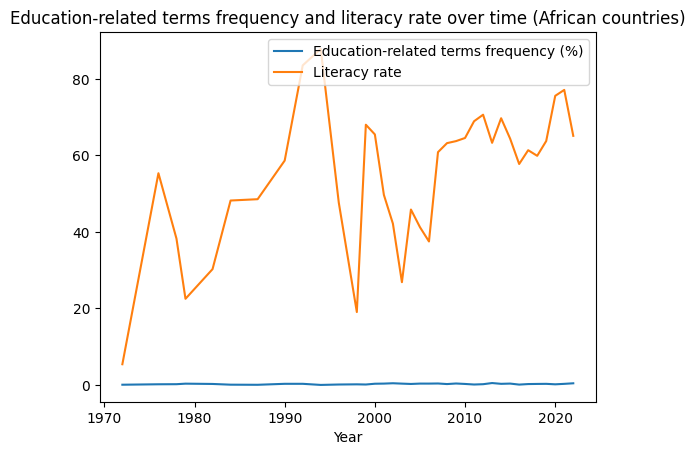

In [18]:
# Plot trends over time: education-related terms frequency and literacy rates together

# aggregate by year
yearly = (df_africa
          .reset_index()
          .groupby('Year', as_index=False)
          .agg(edu_per=('edu_per','mean'),
               edu_total=('edu_total','mean'),
               literacy_rate=('Literacy_Rate','mean')))

plt.figure()
plt.plot(yearly['Year'], yearly['edu_per'], label='Education-related terms frequency (%)')
plt.plot(yearly['Year'], yearly['literacy_rate'], label='Literacy rate')
plt.xlabel('Year')
plt.legend()
plt.title('Education-related terms frequency and literacy rate over time (African countries)')
plt.show()


### 5.2 Literacy Rates Data Overview


Literacy Rate Statistics for African Countries (from df_africa):
count    164.000000
mean      61.956565
std       22.848328
min        5.404650
25%       41.322783
50%       65.016987
75%       81.802794
max       96.199997
Name: Literacy_Rate, dtype: float64


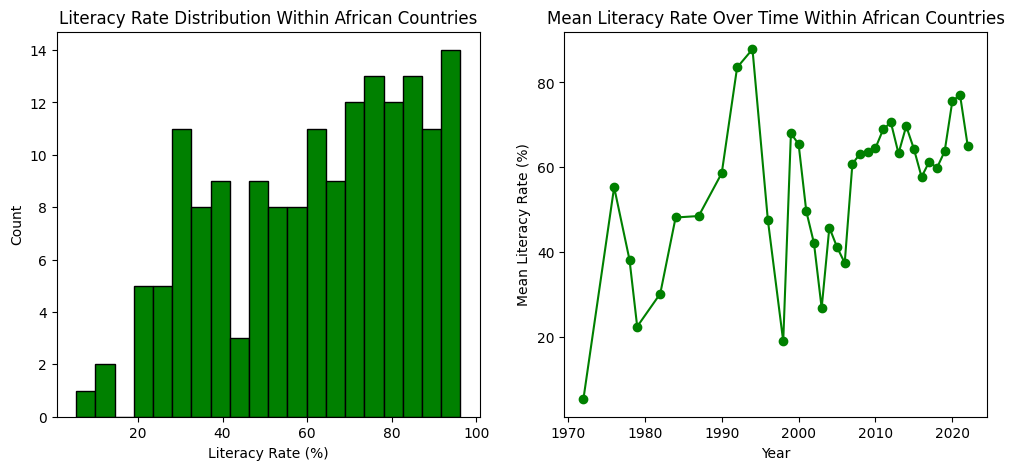

In [19]:
# Analyze literacy rates for African countries using df_africa

# Extract descriptive statistics about the literacy rates in df_africa
print("Literacy Rate Statistics for African Countries (from df_africa):")
print(df_africa['Literacy_Rate'].describe())

# Compute literacy rates over time
literacy_over_time = df_africa.groupby('Year')['Literacy_Rate'].mean().reset_index()

# Adjust the plot size for better readability
plt.figure(figsize=(12, 5))

# Distribution of all literacy rates within African countries
plt.subplot(1, 2, 1)
plt.hist(df_africa['Literacy_Rate'].dropna(), bins=20, color='green', edgecolor='black')
plt.title('Literacy Rate Distribution Within African Countries')
plt.xlabel('Literacy Rate (%)')
plt.ylabel('Count')

# Literacy rates over time within African countries
plt.subplot(1, 2, 2)
plt.plot(literacy_over_time['Year'], literacy_over_time['Literacy_Rate'], marker='o', color='green')
plt.title('Mean Literacy Rate Over Time Within African Countries')
plt.xlabel('Year')
plt.ylabel('Mean Literacy Rate (%)')

# Print the plots
plt.show()


## 6. Research Question Analysis

### 6.1 Exploratory Question: Correlation Between Education Words and Literacy Rates


Normality Check:
Shapiro-Wilk Tests:
Education word frequency: statistic = 0.9231, p-value = 0.0068
Literacy rate: statistic = 0.9477, p-value = 0.0491


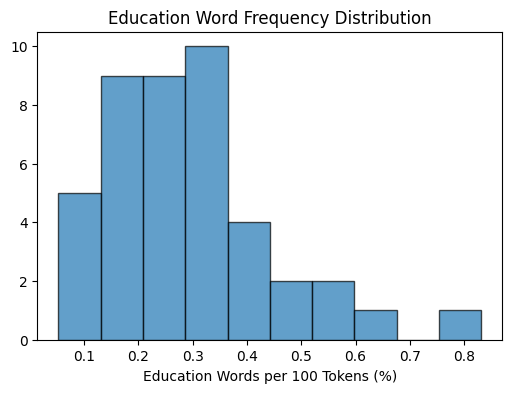

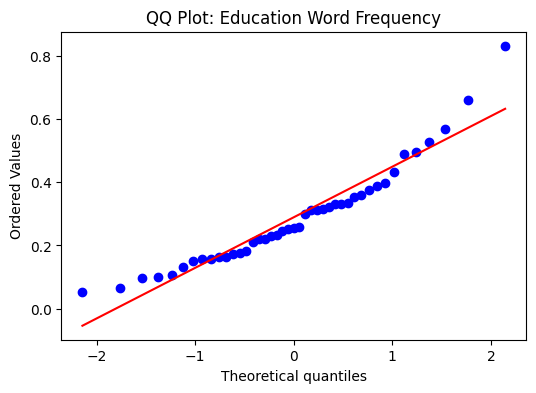

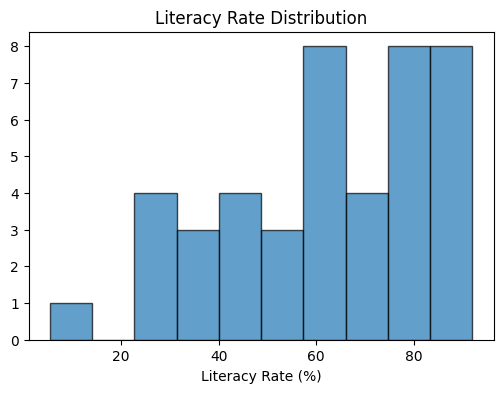

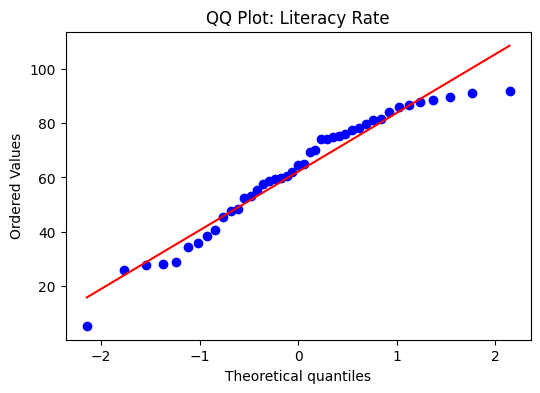

In [20]:
# Calculate mean education word frequency and total education words per country
edu_stats = df_africa.groupby('Country or Area').agg({
    'edu_per': 'mean',
    'n_tokens': 'mean',
    'edu_total': 'mean',
    'Literacy_Rate': 'mean',
    'Education_Expenditure_GDP_Pct': 'mean'  # And mean expenditure
}).reset_index()

# Check the normality of the data distributions: education word frequency and literacy rate
print("\nNormality Check:")

# Shapiro-Wilk tests
stat_edu, p_edu = stats.shapiro(edu_stats['edu_per'])
stat_lit, p_lit = stats.shapiro(edu_stats['Literacy_Rate'])

print("Shapiro-Wilk Tests:")
print(f"Education word frequency: statistic = {stat_edu:.4f}, p-value = {p_edu:.4f}")
print(f"Literacy rate: statistic = {stat_lit:.4f}, p-value = {p_lit:.4f}")

# Education Word Frequency Histogram
plt.figure(figsize=(6, 4))
plt.hist(edu_stats['edu_per'], bins=10, alpha=0.7, edgecolor='black')
plt.title('Education Word Frequency Distribution')
plt.xlabel('Education Words per 100 Tokens (%)')
plt.show()

# QQ Plot: Education Word Frequency
plt.figure(figsize=(6, 4))
stats.probplot(edu_stats['edu_per'], dist="norm", plot=plt)
plt.title('QQ Plot: Education Word Frequency')
plt.show()

# Literacy Rate Histogram
plt.figure(figsize=(6, 4))
plt.hist(edu_stats['Literacy_Rate'], bins=10, alpha=0.7, edgecolor='black')
plt.title('Literacy Rate Distribution')
plt.xlabel('Literacy Rate (%)')
plt.show()


# QQ Plot: Literacy Rate
plt.figure(figsize=(6, 4))
stats.probplot(edu_stats['Literacy_Rate'], dist="norm", plot=plt)
plt.title('QQ Plot: Literacy Rate')
plt.show()


In [21]:
# Correlation analysis between education word frequency and literacy rates

print(f"Countries with education and literacy data: {len(edu_stats)}")
print("\nCountries included in analysis:")
print(edu_stats['Country or Area'].tolist())

print("\nCorrelation Analysis:")
# Pearson correlation for education frequency
corr_freq, p_freq = stats.pearsonr(edu_stats['edu_per'], edu_stats['Literacy_Rate'])
print(f"Pearson correlation (edu words per 100 (%) tokens vs literacy): {corr_freq:.3f} (p={p_freq:.3g})")

# Spearman correlation (rank-based, more robust to outliers)
corr_freq_spear, p_freq_spear = stats.spearmanr(edu_stats['edu_per'], edu_stats['Literacy_Rate'])
print(f"Spearman correlation (edu words per 100 (%) tokens vs literacy): {corr_freq_spear:.3f} (p={p_freq_spear:.3g})")

# Pearson correlation for total education words
corr_total, p_total = stats.pearsonr(edu_stats['edu_total'], edu_stats['Literacy_Rate'])
print(f"Pearson correlation (total edu words vs literacy): {corr_total:.3f} (p={p_total:.3g})")

# Spearman correlation for total education words
corr_total_spear, p_total_spear = stats.spearmanr(edu_stats['edu_total'], edu_stats['Literacy_Rate'])
print(f"Spearman correlation (total edu words vs literacy): {corr_total_spear:.3f} (p={p_total_spear:.3g})")

Countries with education and literacy data: 43

Countries included in analysis:
['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon', 'Ghana', 'Guinea', 'Kenya', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Sao Tome and Principe', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'Sudan', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe']

Correlation Analysis:
Pearson correlation (edu words per 100 (%) tokens vs literacy): -0.134 (p=0.392)
Spearman correlation (edu words per 100 (%) tokens vs literacy): -0.169 (p=0.278)
Pearson correlation (total edu words vs literacy): -0.181 (p=0.247)
Spearman correlation (total edu words vs literacy): -0.221 (p=0.155)


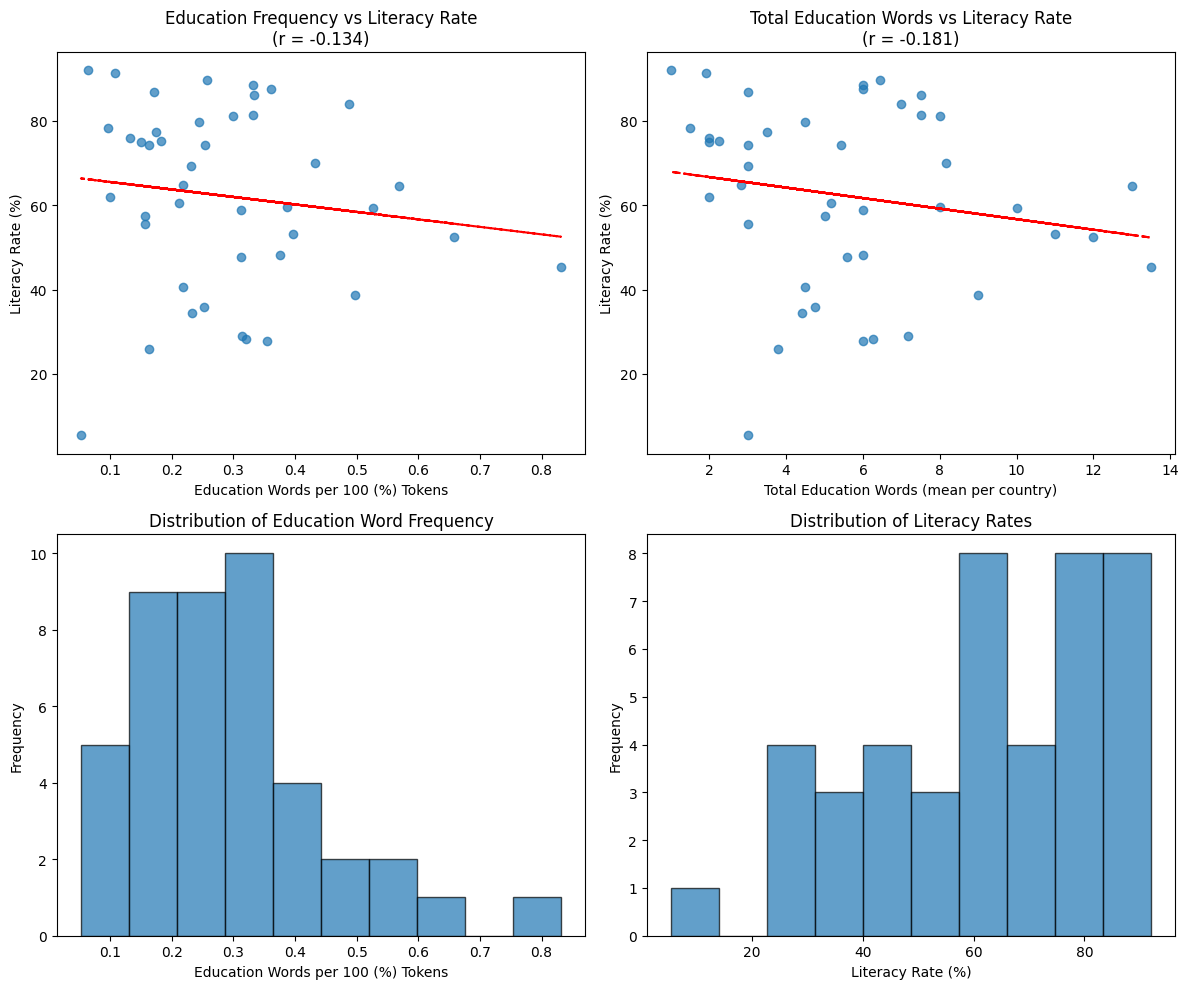


Summary Statistics:
Education word frequency per 100 (%) tokens and literacy rate:
         edu_per  Literacy_Rate
count  43.000000      43.000000
mean    0.289158      62.171781
std     0.162053      21.492290
min     0.052873       5.404650
25%     0.167374      48.016584
50%     0.254087      64.514374
75%     0.357660      79.055843
max     0.831538      92.005573

Total education words and literacy rate:
       edu_total  Literacy_Rate
count  43.000000      43.000000
mean    5.619462      62.171781
std     3.108482      21.492290
min     1.000000       5.404650
25%     3.000000      48.016584
50%     5.428571      64.514374
75%     7.333333      79.055843
max    13.500000      92.005573

Outlier Analysis:
Education frequency outliers (outside -0.12 - 0.64):
   Country or Area   edu_per  Literacy_Rate
11         Eritrea  0.658617      52.513950
13        Ethiopia  0.831538      45.383579

Literacy rate outliers (outside 1.46 - 125.61):
No outliers found

Highest and lowest educati

In [22]:

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Scatter plot: Education word frequency per 100 (%) vs Literacy Rate
axes[0,0].scatter(edu_stats['edu_per'], edu_stats['Literacy_Rate'], alpha=0.7)
if len(edu_stats) > 1:
    z_freq = np.polyfit(edu_stats['edu_per'], edu_stats['Literacy_Rate'], 1)
    axes[0,0].plot(edu_stats['edu_per'], np.polyval(z_freq, edu_stats['edu_per']), "r--")
axes[0,0].set_xlabel('Education Words per 100 (%) Tokens')
axes[0,0].set_ylabel('Literacy Rate (%)')
axes[0,0].set_title(f'Education Frequency vs Literacy Rate\n(r = {corr_freq:.3f})')

# Scatter plot: Total education words vs Literacy Rate
axes[0,1].scatter(edu_stats['edu_total'], edu_stats['Literacy_Rate'], alpha=0.7)
if len(edu_stats) > 1 and edu_stats['edu_total'].nunique() > 1:
    z_total = np.polyfit(edu_stats['edu_total'], edu_stats['Literacy_Rate'], 1)
    axes[0,1].plot(edu_stats['edu_total'], np.polyval(z_total, edu_stats['edu_total']), "r--")
axes[0,1].set_xlabel('Total Education Words (mean per country)')
axes[0,1].set_ylabel('Literacy Rate (%)')
axes[0,1].set_title(f'Total Education Words vs Literacy Rate\n(r = {corr_total:.3f})')

# Histogram of education frequency
axes[1,0].hist(edu_stats['edu_per'], bins=10, alpha=0.7, edgecolor='black')
axes[1,0].set_xlabel('Education Words per 100 (%) Tokens')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Distribution of Education Word Frequency')

# Histogram of literacy rates
axes[1,1].hist(edu_stats['Literacy_Rate'], bins=10, alpha=0.7, edgecolor='black')
axes[1,1].set_xlabel('Literacy Rate (%)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Distribution of Literacy Rates')

plt.tight_layout()
plt.show()

# Print Summary Statistics
print("\nSummary Statistics:")
print("Education word frequency per 100 (%) tokens and literacy rate:")
print(edu_stats[['edu_per', 'Literacy_Rate']].describe())
print("\nTotal education words and literacy rate:")
print(edu_stats[['edu_total', 'Literacy_Rate']].describe())

# --- Outlier Analysis ---
print("\nOutlier Analysis:")

# Identify outliers using IQR method
def identify_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Check for outliers in education frequency
edu_outliers, edu_lower, edu_upper = identify_outliers(edu_stats, 'edu_per')
print(f"Education frequency outliers (outside {edu_lower:.2f} - {edu_upper:.2f}):")
if len(edu_outliers) > 0:
    print(edu_outliers[['Country or Area', 'edu_per', 'Literacy_Rate']])
else:
    print("No outliers found")

# Check for outliers in literacy rate
lit_outliers, lit_lower, lit_upper = identify_outliers(edu_stats, 'Literacy_Rate')
print(f"\nLiteracy rate outliers (outside {lit_lower:.2f} - {lit_upper:.2f}):")
if len(lit_outliers) > 0:
    print(lit_outliers[['Country or Area', 'edu_per', 'Literacy_Rate']])
else:
    print("No outliers found")

# Show countries with highest and lowest education word usage
print(f"\nHighest and lowest education word usage:")
print("Countries with highest education word frequency:")
print(edu_stats.nlargest(3, 'edu_per')[['Country or Area', 'edu_per', 'Literacy_Rate']])
print("\nCountries with lowest education word frequency:")
print(edu_stats.nsmallest(3, 'edu_per')[['Country or Area', 'edu_per', 'Literacy_Rate']])


### 6.2 Predictive Question

In [25]:
#imports
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import (r2_score, mean_absolute_error,root_mean_squared_error,
                             make_scorer)

In [26]:
#prep for analysis
features = ["Education_Expenditure_GDP_Pct", "edu_per"]
target   = "Literacy_Rate"
timecol  = "Year"
test_threshold_year = 2021  # test set = >= 2021

In [27]:
#helper functions
def adj_r2_from_r2(r2, n, p):
    """Adjusted R^2 from plain R^2. p excludes intercept."""
    return np.nan if n <= p + 1 else 1 - (1 - r2) * (n - 1) / (n - p)

def with_const(dfX, feat_order):
    """Add statsmodels-style constant and enforce stable column order."""
    X = dfX[feat_order].copy()
    X = sm.add_constant(X, has_constant='add')
    return X[["const"] + feat_order]

#### Fitting an OLS

In [28]:
#split into train and test set based on 2021 threshold
df_ols = (
    df_africa[features + [target, timecol]]
    .dropna()
    .sort_values(timecol)
    .reset_index(drop=True)
)

train_df = df_ols[df_ols[timecol] < test_threshold_year].copy()
test_df  = df_ols[df_ols[timecol] >= test_threshold_year].copy()

X_train = with_const(train_df, features)
y_train = train_df[target].copy()
X_test  = with_const(test_df, features)
y_test  = test_df[target].copy()

OLS fit and predict for before vs after 2021 + metrics

In [29]:
ols = sm.OLS(y_train, X_train).fit()
print(ols.summary())

# predictions
yhat_train_ols = ols.predict(X_train)
yhat_test_ols  = ols.predict(X_test)

# metrics (consistent names)
rmse_train_ols  = root_mean_squared_error(y_train, yhat_train_ols)
mae_train_ols   = mean_absolute_error(y_train, yhat_train_ols)
r2_train_ols    = r2_score(y_train, yhat_train_ols)
adjr2_train_ols = ols.rsquared_adj

rmse_test_ols  = root_mean_squared_error(y_test, yhat_test_ols)
mae_test_ols   = mean_absolute_error(y_test, yhat_test_ols)
r2_test_ols    = r2_score(y_test, yhat_test_ols)
p_ols          = len(features)  # exclude intercept
adjr2_test_ols = adj_r2_from_r2(r2_test_ols, len(y_test), p_ols)

print("\n[OLS] Performance")
print(f"  Train → RMSE: {rmse_train_ols:.4f}, MAE: {mae_train_ols:.4f}, R²: {r2_train_ols:.4f}, Adj.R²: {adjr2_train_ols:.4f}")
print(f"   Test → RMSE: {rmse_test_ols:.4f}, MAE: {mae_test_ols:.4f}, R²: {r2_test_ols:.4f}, Adj.R²: {adjr2_test_ols:.4f}")


                            OLS Regression Results                            
Dep. Variable:          Literacy_Rate   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     15.17
Date:                Sun, 28 Sep 2025   Prob (F-statistic):           1.10e-06
Time:                        19:17:18   Log-Likelihood:                -633.05
No. Observations:                 142   AIC:                             1272.
Df Residuals:                     139   BIC:                             1281.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

Visual for OLS in 3D

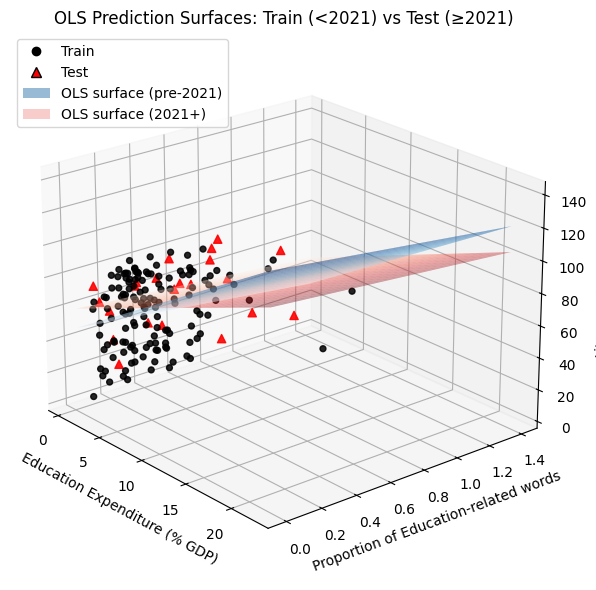


== OLS (pre-2021) params ==
const                            47.430582
Education_Expenditure_GDP_Pct     4.072257
edu_per                         -12.646958
dtype: float64

== OLS (2021+) params ==
const                            60.191288
Education_Expenditure_GDP_Pct     2.560336
edu_per                          -8.884437
dtype: float64


In [30]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

f1, f2 = features

# Fit separate planes for viz only (same spec)
X_pre  = with_const(train_df, features);  y_pre  = train_df[target]
X_post = with_const(test_df,  features);  y_post = test_df[target]
ols_pre  = sm.OLS(y_pre,  X_pre).fit()
ols_post = sm.OLS(y_post, X_post).fit()

# grid over full range
g1 = np.linspace(df_ols[f1].min(), df_ols[f1].max(), 60)
g2 = np.linspace(df_ols[f2].min(), df_ols[f2].max(), 60)
G1, G2 = np.meshgrid(g1, g2)
grid_df = pd.DataFrame({f1: G1.ravel(), f2: G2.ravel()})
GX_pre  = with_const(grid_df, features).reindex(columns=X_pre.columns)
GX_post = with_const(grid_df, features).reindex(columns=X_post.columns)

Z_pre  = ols_pre.predict(GX_pre).values.reshape(G1.shape)
Z_post = ols_post.predict(GX_post).values.reshape(G1.shape)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(G1, G2, Z_pre,  alpha=0.55, linewidth=0, antialiased=True, cmap='Blues')
ax.plot_surface(G1, G2, Z_post, alpha=0.40, linewidth=0, antialiased=True, cmap='Reds')

ax.scatter(train_df[f1], train_df[f2], y_pre,  c='k', s=18, alpha=0.85)
ax.scatter(test_df[f1],  test_df[f2],  y_post, c='r', s=35, alpha=0.9, marker='^')

ax.set_xlabel("Education Expenditure (% GDP)")
ax.set_ylabel("Proportion of Education-related words")
ax.set_zlabel(target)
ax.set_title("OLS Prediction Surfaces: Train (<2021) vs Test (≥2021)")
ax.view_init(elev=22, azim=-40)

legend_handles = [
    Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markersize=6, label='Train'),
    Line2D([0], [0], marker='^', color='none', markerfacecolor='r', markersize=7, label='Test'),
    Patch(facecolor='steelblue',  alpha=0.55, label='OLS surface (pre-2021)'),
    Patch(facecolor='lightcoral', alpha=0.40, label='OLS surface (2021+)'),
]
ax.legend(handles=legend_handles, loc='upper left')
plt.tight_layout(); plt.show()

print("\n== OLS (pre-2021) params ==")
print(ols_pre.params)
print("\n== OLS (2021+) params ==")
print(ols_post.params)

TimeSeriesSplit Cross-Validation for OLS

In [31]:
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
import numpy as np

# your functions
def adjusted_r2_score(y_true, y_pred, n_features):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true); p = n_features
    return adj_r2_from_r2(r2, n, p)

def adj_r2_scorer_func(estimator, X, y):
    y_pred = estimator.predict(X)
    return adjusted_r2_score(y, y_pred, X.shape[1])

ols_skl = LinearRegression()
tscv = TimeSeriesSplit(n_splits=5)

# use your scorer directly (no make_scorer around estimator-aware func)
scorers = {
    "r2": "r2",
    "rmse": "neg_root_mean_squared_error",
    "mae": make_scorer(mean_absolute_error, greater_is_better=False),
    "adj_r2": adj_r2_scorer_func
}

cv_scores = cross_validate(
    ols_skl,
    df_ols[features].values, df_ols[target].values,
    cv=tscv,
    scoring=scorers,
    return_train_score=False
)

r2_cv_mean_ols    = np.nanmean(cv_scores["test_r2"])
r2_cv_std_ols     = np.nanstd(cv_scores["test_r2"])
adjr2_cv_mean_ols = np.nanmean(cv_scores["test_adj_r2"])
adjr2_cv_std_ols  = np.nanstd(cv_scores["test_adj_r2"])
rmse_cv_mean_ols  = -np.nanmean(cv_scores["test_rmse"])
rmse_cv_std_ols   = np.nanstd(cv_scores["test_rmse"])
mae_cv_mean_ols   = -np.nanmean(cv_scores["test_mae"])
mae_cv_std_ols    = np.nanstd(cv_scores["test_mae"])

print("\n[OLS] TimeSeries CV (5 splits)")
print(f"  R² (mean ± sd):      {r2_cv_mean_ols:.3f} ± {r2_cv_std_ols:.3f}")
print(f"  Adj. R² (mean ± sd): {adjr2_cv_mean_ols:.3f} ± {adjr2_cv_std_ols:.3f}")
print(f"  RMSE (mean ± sd):    {rmse_cv_mean_ols:.3f} ± {rmse_cv_std_ols:.3f}")
print(f"  MAE (mean ± sd):     {mae_cv_mean_ols:.3f} ± {mae_cv_std_ols:.3f}")



[OLS] TimeSeries CV (5 splits)
  R² (mean ± sd):      -0.129 ± 0.202
  Adj. R² (mean ± sd): -0.174 ± 0.210
  RMSE (mean ± sd):    22.188 ± 1.771
  MAE (mean ± sd):     19.721 ± 1.125


Assumptions Check for OLS

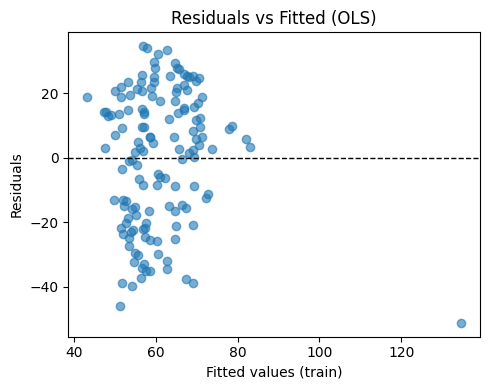

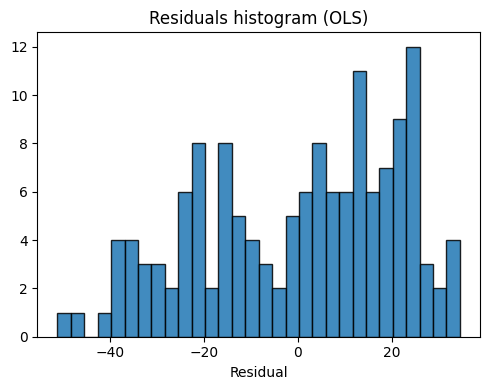

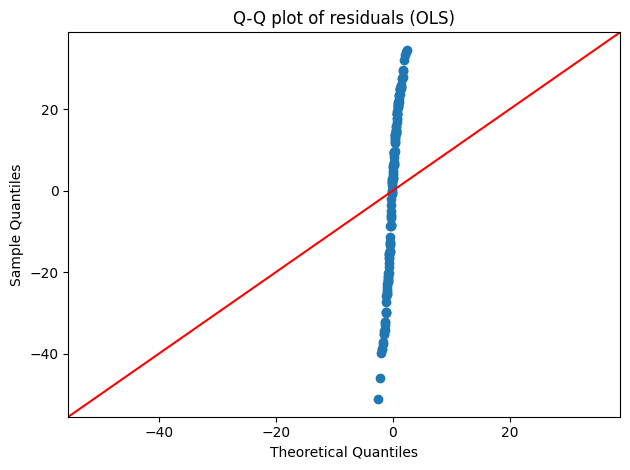

LM stat: 3.9965
LM p-value: 0.1356
F-stat: 2.0127
F p-value: 0.1375

Durbin–Watson (OLS): 1.810 (≈2 = no autocorrelation)

Variance Inflation Factors (OLS):
                         feature       VIF
0  Education_Expenditure_GDP_Pct  1.855243
1                        edu_per  1.855243


In [32]:
resid_ols  = y_train - yhat_train_ols
fitted_ols = yhat_train_ols

plt.figure(figsize=(5,4))
plt.scatter(fitted_ols, resid_ols, alpha=0.6)
plt.axhline(0, color="k", linestyle="--", linewidth=1)
plt.xlabel("Fitted values (train)"); plt.ylabel("Residuals"); plt.title("Residuals vs Fitted (OLS)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(5,4))
plt.hist(resid_ols, bins=30, alpha=0.85, edgecolor="k")
plt.xlabel("Residual"); plt.title("Residuals histogram (OLS)")
plt.tight_layout(); plt.show()

qqplot(resid_ols, line='45')
plt.title("Q-Q plot of residuals (OLS)")
plt.tight_layout(); plt.show()

bp_test_ols = het_breuschpagan(resid_ols, X_train)
for lab, val in zip(["LM stat","LM p-value","F-stat","F p-value"], bp_test_ols):
    print(f"{lab}: {val:.4f}")

dw_ols = durbin_watson(resid_ols)
print(f"\nDurbin–Watson (OLS): {dw_ols:.3f} (≈2 = no autocorrelation)")

# VIF: compute on features only
X_for_vif = X_train.drop(columns=["const"]).values
vif_df_ols = pd.DataFrame({
    "feature": features,
    "VIF": [variance_inflation_factor(X_for_vif, i) for i in range(X_for_vif.shape[1])]
})
print("\nVariance Inflation Factors (OLS):")
print(vif_df_ols)

#### Model Selection

Polynomial regression

In [33]:
poly2 = PolynomialFeatures(degree=2, include_bias=False)
lin   = LinearRegression(fit_intercept=True)

Xtr_poly2 = poly2.fit_transform(train_df[features].values)
Xte_poly2 = poly2.transform(test_df[features].values)

lin.fit(Xtr_poly2, y_train)
yhat_train_poly2 = lin.predict(Xtr_poly2)
yhat_test_poly2  = lin.predict(Xte_poly2)

p_poly2            = Xtr_poly2.shape[1]
rmse_train_poly2   = root_mean_squared_error(y_train, yhat_train_poly2)
mae_train_poly2    = mean_absolute_error(y_train, yhat_train_poly2)
r2_train_poly2     = r2_score(y_train, yhat_train_poly2)
adjr2_train_poly2  = adj_r2_from_r2(r2_train_poly2, len(y_train), p_poly2)

rmse_test_poly2    = root_mean_squared_error(y_test, yhat_test_poly2)
mae_test_poly2     = mean_absolute_error(y_test, yhat_test_poly2)
r2_test_poly2      = r2_score(y_test, yhat_test_poly2)
adjr2_test_poly2   = adj_r2_from_r2(r2_test_poly2, len(y_test), p_poly2)

print("\n[Polynomial deg=2] Performance")
print(f"  Train → RMSE: {rmse_train_poly2:.4f}, MAE: {mae_train_poly2:.4f}, R²: {r2_train_poly2:.4f}, Adj.R²: {adjr2_train_poly2:.4f}")
print(f"   Test → RMSE: {rmse_test_poly2:.4f}, MAE: {mae_test_poly2:.4f}, R²: {r2_test_poly2:.4f}, Adj.R²: {adjr2_test_poly2:.4f}")



[Polynomial deg=2] Performance
  Train → RMSE: 19.6953, MAE: 16.6788, R²: 0.2701, Adj.R²: 0.2488
   Test → RMSE: 19.5909, MAE: 17.3556, R²: 0.0159, Adj.R²: -0.2156


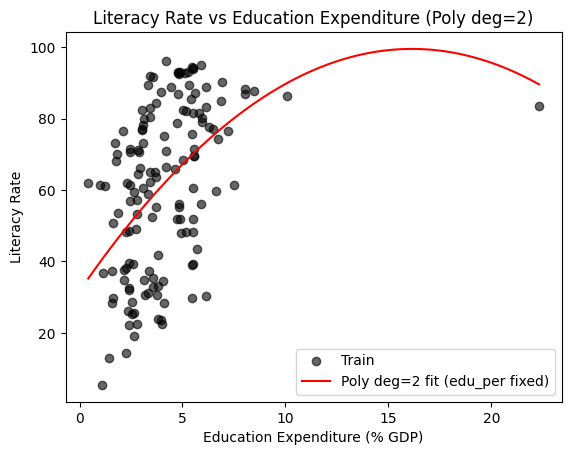

In [34]:
exp_range = np.linspace(train_df[features[0]].min(), train_df[features[0]].max(), 100)
edu_fixed = np.full_like(exp_range, train_df[features[1]].mean())
X_plot = np.column_stack([exp_range, edu_fixed])
y_plot_poly2 = lin.predict(poly2.transform(X_plot))
plt.scatter(train_df[features[0]], y_train, color="black", alpha=0.6, label="Train")
plt.plot(exp_range, y_plot_poly2, color="red", label="Poly deg=2 fit (edu_per fixed)")
plt.xlabel("Education Expenditure (% GDP)"); plt.ylabel("Literacy Rate")
plt.title("Literacy Rate vs Education Expenditure (Poly deg=2)")
plt.legend(); plt.show()

GridSearchCV for polynomial model

In [35]:
tscv = TimeSeriesSplit(n_splits=5)
pipe_poly = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('lin', LinearRegression())
])
param_grid_poly = {
    'poly__degree': [1, 2, 3, 4, 5],
    'lin__fit_intercept': [True, False]
}
grid_poly = GridSearchCV(pipe_poly, param_grid_poly, cv=tscv, scoring='r2')
grid_poly.fit(train_df[features].values, y_train.values)
print("\n[Polynomial GridSearch] Best params:", grid_poly.best_params_)

yhat_train_poly = grid_poly.best_estimator_.predict(train_df[features].values)
yhat_test_poly  = grid_poly.best_estimator_.predict(test_df[features].values)
p_poly = grid_poly.best_estimator_.named_steps['poly'].fit_transform(train_df[features].values).shape[1]

rmse_train_poly   = root_mean_squared_error(y_train, yhat_train_poly)
mae_train_poly    = mean_absolute_error(y_train, yhat_train_poly)
r2_train_poly     = r2_score(y_train, yhat_train_poly)
adjr2_train_poly  = adj_r2_from_r2(r2_train_poly, len(y_train), p_poly)

rmse_test_poly    = root_mean_squared_error(y_test, yhat_test_poly)
mae_test_poly     = mean_absolute_error(y_test, yhat_test_poly)
r2_test_poly      = r2_score(y_test, yhat_test_poly)
adjr2_test_poly   = adj_r2_from_r2(r2_test_poly, len(y_test), p_poly)

print("\n[Polynomial best] Performance")
print(f"  Train → RMSE: {rmse_train_poly:.4f}, MAE: {mae_train_poly:.4f}, R²: {r2_train_poly:.4f}, Adj.R²: {adjr2_train_poly:.4f}")
print(f"   Test → RMSE: {rmse_test_poly:.4f}, MAE: {mae_test_poly:.4f}, R²: {r2_test_poly:.4f}, Adj.R²: {adjr2_test_poly:.4f}")



[Polynomial GridSearch] Best params: {'lin__fit_intercept': False, 'poly__degree': 2}

[Polynomial best] Performance
  Train → RMSE: 20.4232, MAE: 17.1426, R²: 0.2152, Adj.R²: 0.1923
   Test → RMSE: 20.8622, MAE: 18.0390, R²: -0.1160, Adj.R²: -0.3785


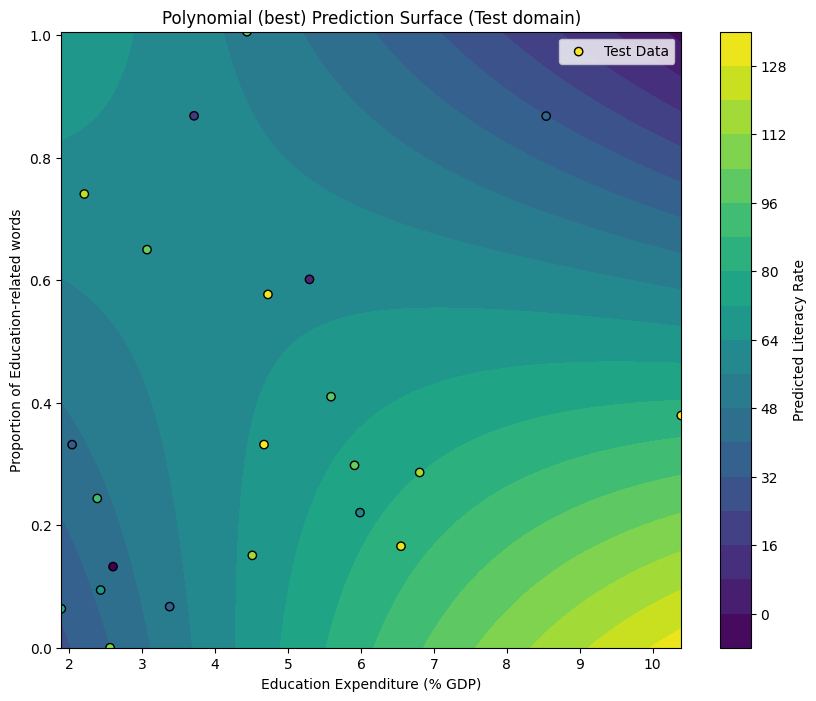

In [36]:
# Contour over test domain for best polynomial
exp_min, exp_max = test_df[features[0]].min(), test_df[features[0]].max()
edu_min, edu_max = test_df[features[1]].min(), test_df[features[1]].max()
exp_grid, edu_grid = np.meshgrid(np.linspace(exp_min, exp_max, 100),
                                 np.linspace(edu_min, edu_max, 100))
X_grid = np.column_stack([exp_grid.ravel(), edu_grid.ravel()])
y_grid_poly = grid_poly.best_estimator_.predict(X_grid).reshape(exp_grid.shape)

plt.figure(figsize=(10, 8))
contour = plt.contourf(exp_grid, edu_grid, y_grid_poly, levels=20, cmap='viridis')
plt.colorbar(contour, label='Predicted Literacy Rate')
plt.scatter(test_df[features[0]], test_df[features[1]], c=y_test, edgecolors='k', label='Test Data', cmap='viridis')
plt.xlabel("Education Expenditure (% GDP)")
plt.ylabel("Proportion of Education-related words")
plt.title("Polynomial (best) Prediction Surface (Test domain)")
plt.legend(); plt.show()


[Gradient Boosting] Best params: {'gb__learning_rate': 0.01, 'gb__max_depth': 2, 'gb__n_estimators': 300}

[Gradient Boosting best] Performance
  Train → RMSE: 16.6556, MAE: 14.2073, R²: 0.4780, Adj.R²: 0.4743
   Test → RMSE: 20.0613, MAE: 18.1008, R²: -0.0319, Adj.R²: -0.0835


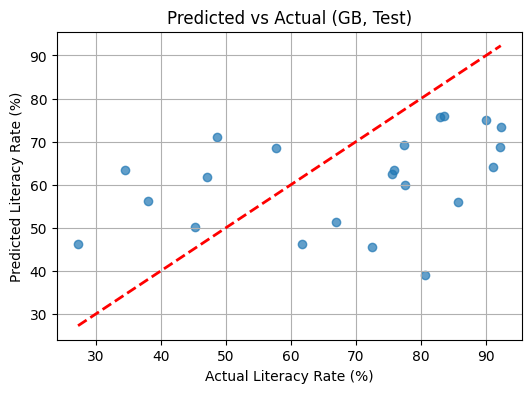

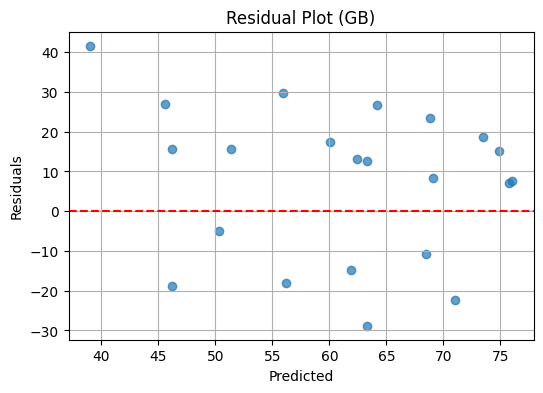

In [37]:
pipe_gb = Pipeline([('gb', GradientBoostingRegressor(min_samples_split=5,
                                                     loss="squared_error",
                                                     random_state=42))])
param_grid_gb = {
    'gb__n_estimators': [300, 700, 1200],
    'gb__max_depth':    [2, 3, 5],
    'gb__learning_rate':[0.01, 0.05, 0.1],
}
grid_gb = GridSearchCV(pipe_gb, param_grid_gb, cv=tscv, scoring='r2')
grid_gb.fit(train_df[features].values, y_train.values)
print("\n[Gradient Boosting] Best params:", grid_gb.best_params_)

yhat_train_gb = grid_gb.best_estimator_.predict(train_df[features].values)
yhat_test_gb  = grid_gb.best_estimator_.predict(test_df[features].values)

rmse_train_gb  = root_mean_squared_error(y_train, yhat_train_gb)
mae_train_gb   = mean_absolute_error(y_train, yhat_train_gb)
r2_train_gb    = r2_score(y_train, yhat_train_gb)
adjr2_train_gb = adj_r2_from_r2(r2_train_gb, len(y_train), len(features))

rmse_test_gb   = root_mean_squared_error(y_test, yhat_test_gb)
mae_test_gb    = mean_absolute_error(y_test, yhat_test_gb)
r2_test_gb     = r2_score(y_test, yhat_test_gb)
adjr2_test_gb  = adj_r2_from_r2(r2_test_gb, len(y_test), len(features))

print("\n[Gradient Boosting best] Performance")
print(f"  Train → RMSE: {rmse_train_gb:.4f}, MAE: {mae_train_gb:.4f}, R²: {r2_train_gb:.4f}, Adj.R²: {adjr2_train_gb:.4f}")
print(f"   Test → RMSE: {rmse_test_gb:.4f}, MAE: {mae_test_gb:.4f}, R²: {r2_test_gb:.4f}, Adj.R²: {adjr2_test_gb:.4f}")

# Pred vs Actual + Residuals
plt.figure(figsize=(6,4))
plt.scatter(y_test, yhat_test_gb, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual Literacy Rate (%)"); plt.ylabel("Predicted Literacy Rate (%)")
plt.title("Predicted vs Actual (GB, Test)"); plt.grid(True); plt.show()

residuals_gb = y_test - yhat_test_gb
plt.figure(figsize=(6,4))
plt.scatter(yhat_test_gb, residuals_gb, alpha=0.7)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted"); plt.ylabel("Residuals"); plt.title("Residual Plot (GB)")
plt.grid(True); plt.show()

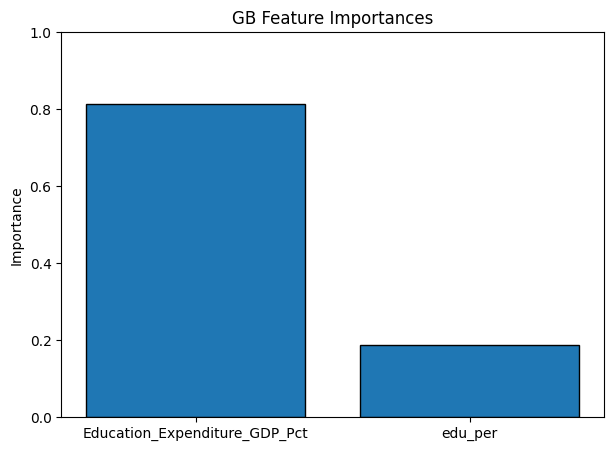

In [38]:
# Feature importances
fi_gb = grid_gb.best_estimator_.named_steps['gb'].feature_importances_
plt.figure(figsize=(7,5))
plt.bar(features, fi_gb, edgecolor='black')
plt.ylabel("Importance"); plt.title("GB Feature Importances"); plt.ylim(0, 1); plt.show()


K Nearest Neighbor Method with Grid Search



[KNN] Best params: {'knn__n_neighbors': 10, 'knn__weights': 'uniform'}

[KNN best] Performance
  Train → RMSE: 18.6034, MAE: 15.6327, R²: 0.3488, Adj.R²: 0.3442
   Test → RMSE: 20.8697, MAE: 18.2736, R²: -0.1167, Adj.R²: -0.1726


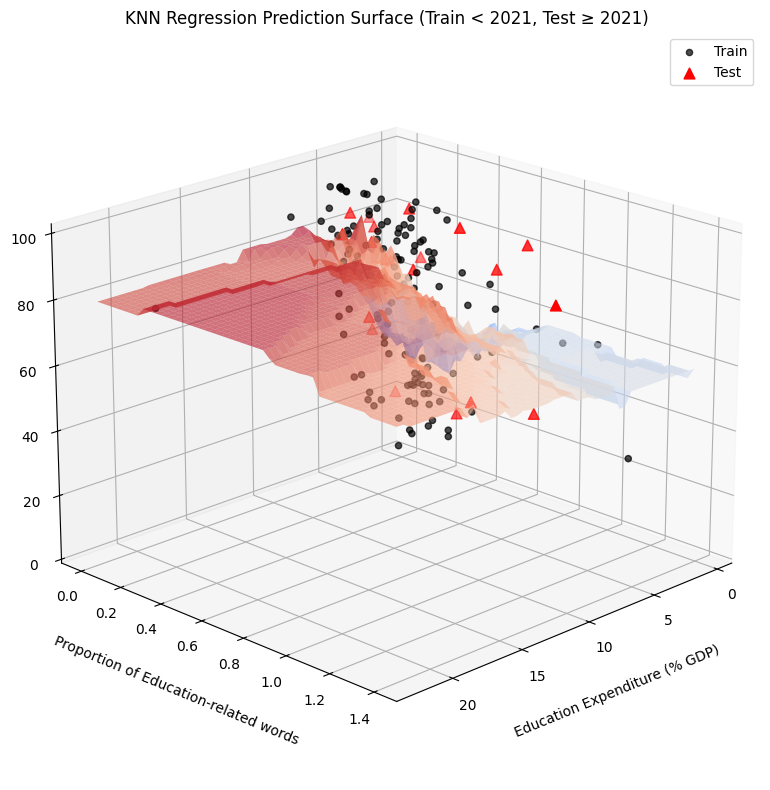

In [39]:
pipe_knn = Pipeline([
    ('sc', StandardScaler()),
    ('knn', KNeighborsRegressor())
])
param_grid_knn = {
    'knn__n_neighbors': [3, 5, 7, 10, 15],
    'knn__weights': ['uniform', 'distance']
}
grid_knn = GridSearchCV(pipe_knn, param_grid_knn, cv=tscv, scoring='r2')
grid_knn.fit(train_df[features].values, y_train.values)
print("\n[KNN] Best params:", grid_knn.best_params_)

yhat_train_knn = grid_knn.best_estimator_.predict(train_df[features].values)
yhat_test_knn  = grid_knn.best_estimator_.predict(test_df[features].values)

rmse_train_knn  = root_mean_squared_error(y_train, yhat_train_knn)
mae_train_knn   = mean_absolute_error(y_train, yhat_train_knn)
r2_train_knn    = r2_score(y_train, yhat_train_knn)
adjr2_train_knn = adj_r2_from_r2(r2_train_knn, len(y_train), len(features))

rmse_test_knn   = root_mean_squared_error(y_test, yhat_test_knn)
mae_test_knn    = mean_absolute_error(y_test, yhat_test_knn)
r2_test_knn     = r2_score(y_test, yhat_test_knn)
adjr2_test_knn  = adj_r2_from_r2(r2_test_knn, len(y_test), len(features))

print("\n[KNN best] Performance")
print(f"  Train → RMSE: {rmse_train_knn:.4f}, MAE: {mae_train_knn:.4f}, R²: {r2_train_knn:.4f}, Adj.R²: {adjr2_train_knn:.4f}")
print(f"   Test → RMSE: {rmse_test_knn:.4f}, MAE: {mae_test_knn:.4f}, R²: {r2_test_knn:.4f}, Adj.R²: {adjr2_test_knn:.4f}")

# 3D surface for KNN across train domain
exp_range3d = np.linspace(train_df[features[0]].min(), train_df[features[0]].max(), 50)
edu_range3d = np.linspace(train_df[features[1]].min(), train_df[features[1]].max(), 50)
exp_grid3d, edu_grid3d = np.meshgrid(exp_range3d, edu_range3d)
X_grid3d = np.column_stack([exp_grid3d.ravel(), edu_grid3d.ravel()])
y_grid_knn = grid_knn.best_estimator_.predict(X_grid3d).reshape(exp_grid3d.shape)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(exp_grid3d, edu_grid3d, y_grid_knn, cmap="coolwarm", alpha=0.6)
ax.scatter(train_df[features[0]], train_df[features[1]], y_train, color="black", label="Train", alpha=0.7)
ax.scatter(test_df[features[0]],  test_df[features[1]],  y_test,  color="red", marker="^", s=60, label="Test")
ax.set_xlabel("Education Expenditure (% GDP)", labelpad=15)
ax.set_ylabel("Proportion of Education-related words", labelpad=15)
ax.set_zlabel("Literacy Rate", labelpad=20)
ax.set_title("KNN Regression Prediction Surface (Train < 2021, Test ≥ 2021)")
ax.view_init(elev=20, azim=45)
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

#### Summary Table

In [40]:
train_metrics = pd.DataFrame({
    "RMSE":   [rmse_train_ols,  rmse_train_poly2,  rmse_train_poly,  rmse_train_gb,  rmse_train_knn],
    "MAE":    [mae_train_ols,   mae_train_poly2,   mae_train_poly,   mae_train_gb,   mae_train_knn],
    "R2":     [r2_train_ols,    r2_train_poly2,    r2_train_poly,    r2_train_gb,    r2_train_knn],
    "Adj_R2": [adjr2_train_ols, adjr2_train_poly2, adjr2_train_poly, adjr2_train_gb, adjr2_train_knn],
}, index=["OLS", "Poly (deg=2)", "Poly (best)", "GB (best)", "KNN (best)"])

test_metrics = pd.DataFrame({
    "RMSE":   [rmse_test_ols,  rmse_test_poly2,  rmse_test_poly,  rmse_test_gb,  rmse_test_knn],
    "MAE":    [mae_test_ols,   mae_test_poly2,   mae_test_poly,   mae_test_gb,   mae_test_knn],
    "R2":     [r2_test_ols,    r2_test_poly2,    r2_test_poly,    r2_test_gb,    r2_test_knn],
    "Adj_R2": [adjr2_test_ols, adjr2_test_poly2, adjr2_test_poly, adjr2_test_gb, adjr2_test_knn],
}, index=["OLS", "Poly (deg=2)", "Poly (best)", "GB (best)", "KNN (best)"])

print("\n=== Train Metrics ===")
print(train_metrics.round(4))
print("\n=== Test Metrics ===")
print(test_metrics.round(4))


=== Train Metrics ===
                 RMSE      MAE      R2  Adj_R2
OLS           20.8870  17.9625  0.1791  0.1673
Poly (deg=2)  19.6953  16.6788  0.2701  0.2488
Poly (best)   20.4232  17.1426  0.2152  0.1923
GB (best)     16.6556  14.2073  0.4780  0.4743
KNN (best)    18.6034  15.6327  0.3488  0.3442

=== Test Metrics ===
                 RMSE      MAE      R2  Adj_R2
OLS           20.5692  18.5268 -0.0848 -0.1391
Poly (deg=2)  19.5909  17.3556  0.0159 -0.2156
Poly (best)   20.8622  18.0390 -0.1160 -0.3785
GB (best)     20.0613  18.1008 -0.0319 -0.0835
KNN (best)    20.8697  18.2736 -0.1167 -0.1726
